# Initial Model

Here is the introductory tutorial example from Mesa. As with any model, we must start with some assumptions. For this case on economics, we know that there are some number of agents; all agents begin with 1 unit of money, and at every step of the model, an agent gives 1 unit of money (if they have it) to some other agent. 

  0%|          | 0/133 [00:00<?, ?it/s]

'\ngini = model.datacollector.get_model_vars_dataframe()\nh = sns.lineplot(data=gini)\nh.set(title="Gini Coefficient over time", ylabel="Gini Coefficient");\n\nagent_wealth = model.datacollector.get_agent_vars_dataframe()\nagent_wealth.head()\n'

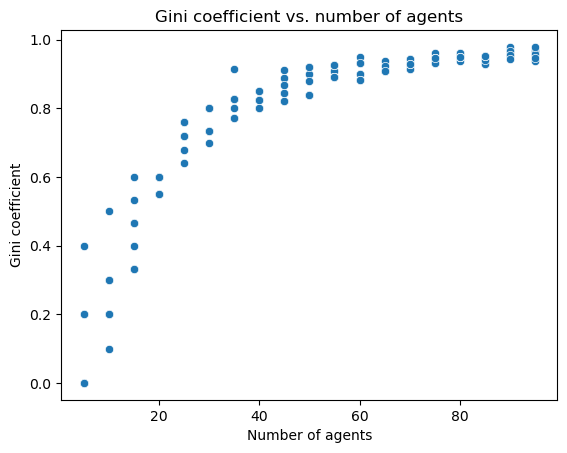

In [15]:
"""Having installed Mesa and Seaborn in the Anaconda Powershell Prompt using pip, we now import them as well as others: Seaborn for data visualization, 
numpy for mathematical functions, pandas for data analysis"""

import mesa
import seaborn as sns
import numpy as np
import pandas as pd

"""We create a new class that extends mesa.Agent, creating a subclass of the Agent class from Mesa. The agent's step method is called by the scheduler 
during each step of the model. The model.random random_number generator is used to allow the agent to randomly choose another agent; the scheduler has 
an internal list of the agents it is scheduled to activate so that agents can be picked at random. Adding to the agents' behaviors, we use the 
move_agent method and get_neighborhood method to move the agents around neighboring cells. The get_neighborhood method can get two types of cell 
neighborhoods: Moore and Von Neumann. It also needs an argument as to whether to include the center cell itself as one of the neighbors. To get all the 
other agents present in a cell, we can use the get_cell_list_contents method.""" 

class MoneyAgent(mesa.Agent):
    """An agent with fixed initial wealth"""
    def __init__(self, unique_id, model):
        # To pass the parameters to the parent class
        super().__init__(unique_id, model)
        # To create the agent's variable and set the initial values
        self.wealth = 1
        self.steps_not_given = 0 

    def step(self):
        """The agent's step: the agent's wealth is verified, and if it has enough money, it gives money by calling the give_money function"""
        self.move()
        if self.wealth > 0: 
            self.give_money()
        else: 
            self.steps_not_given += 1

    def move(self):
        """To move the agent around"""
        possible_steps = self.model.grid.get_neighborhood(self.pos, moore=True, include_center=False)
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        # To ensure that the agent is not giving money to itself
        cellmates.pop(cellmates.index(self))
        if len(cellmates) > 1: 
            other = self.random.choice(cellmates)
            other.wealth =+ 1 
            self.wealth -= 1
            self.steps_not_given = 0 
        else: 
            self.steps_not_given += 1

"""We create a new class that extends mesa.Model and calls super().__init__(), creating a subclass of the Model class from Mesa. A new class named 
RandomActivationByAgent is created which extends mesa.time.RandomActivation, creating a subclass of the RandomActivation class from Mesa. This class 
activates all the agents once per step, in random order. Every agent is expected to have a step method. We add an agent to the schedule using the add 
method. When we call the schedule's step method, the model shuffles the order of the agents, then activates and executes each agent's step method. The 
scheduler is then added to the model. Adding space to the model, since we want agents to be able to share a cell, we use MultiGrid. Similar to mesa.time,
context is retained with mesa.space.[enter_class]. We instantiate a grid with width and height parameters, and a boolean as to whether the grid is 
toroidal. We can place agents on a grid with the grid's place_agent method, which takes an agent and an (x, y) tuple of the coordinates to place the 
agent. Each agent's position is stored in two ways: the agent is contained in the grid in the cell is it currently in, and the agent has a pos variable 
with an (x, y) coordinate tuple. The place_agent method adds the coordinate to the agent automatically.""" 

"""We now use the data collector to collect the data of each step. When the data collector's collect method is called, with a model object as its
argument, it applies each model-level collection function to the model and stores the results in a dictionary, associating the current value with the 
current step of the model. Similarly, the method applies each agent-level collection function to each agent currently in the schedule, associating the 
resulting value with the step of the model, and the agent's unique_id. Our data collector collects every agent's wealth and the model's Gini Coefficient
at each step."""

def compute_gini(model):
    agent_wealths = [agent.wealth for agent in model.schedule.agents]
    x = sorted(agent_wealths)
    N = model.num_agents
    B = sum(xi * (N - i) for i, xi in enumerate(x)) / (N * sum(x))
    return 1 + (1 / N) - 2 * B

class MoneyModel(mesa.Model):
    """A model with some number of agents"""
    def __init__(self, N, width, height):
        super().__init__()
        self.num_agents = N
        self.grid = mesa.space.MultiGrid(width, height, True)
        # To create a scheduler and assign it to the model
        self.schedule = mesa.time.RandomActivation(self)
        # For the batchrunner: enables conditional shut off of the model
        self.running = True 
        # To create agents 
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            # To add the agent to the scheduler
            self.schedule.add(a)
            # To add the agent to a random grid cell 
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))
        self.datacollector = mesa.DataCollector(model_reporters={"Gini": compute_gini}, agent_reporters={"Wealth": "wealth"})
        
    def step(self):
        """Advance the model by one step"""
        # The model's step goes here
        self.datacollector.collect(self)
        self.schedule.step()

"""
We create a batchrunner to calculate the number of consecutive time steps an agent hasn't given any wealth as an agent reporter. We hold the height and 
width fixed but vary the number of agents. We tell the batchrunner to run 5 instantiations of the model with each number of agents and to run each for 
100 steps. We then convert the list of dictionaries to a Pandas dataframe and analyze the results""" 

p = {"width": 10, "height": 10, "N": range(5, 100, 5)}
results = mesa.batch_run(MoneyModel, parameters=p, iterations=7, max_steps=100, number_processes=1, data_collection_period=1, display_progress=True)
results_df = pd.DataFrame(results)
results_filtered = results_df[(results_df.AgentID == 0) & (results_df.Step == 100)]
results_filtered[["iteration", "N", "Gini"]].reset_index(drop=True).head()  
g = sns.scatterplot(data=results_filtered, x="N", y="Gini")
g.set(xlabel="Number of agents", ylabel="Gini coefficient", title="Gini coefficient vs. number of agents");

# Other executions 
"""To see the distribution of the agent's wealth, we can get the wealth values with list comprehension and then use Seaborn to visualize it. To run the
model 100 times, each model executing 10 steps, we execute the following:"""  



"""We create a model with 100 agents on a 10x10 grid and run it for 20 steps. We use seaborn and numpy to visualize the number of agents residing in 
each cell. We also get the series of Gini coefficients as a pandas DataFrame and plot it over time""" 

"""
model = MoneyModel(100, 10, 10)
for i in range(100): 
    model.step() 
"""

"""
agent_counts = np.zeros((model.grid.width, model.grid.height))
for cell_content, (x, y) in model.grid.coord_iter():
    agent_count = len(cell_content)
    agent_counts[x][y] = agent_count
g = sns.heatmap(agent_counts, cmap="viridis", annot=True, cbar=False, square=True)
g.figure.set_size_inches(4, 4)
g.set(title="Number of agents on each cell of the grid");"""

"""
gini = model.datacollector.get_model_vars_dataframe()
h = sns.lineplot(data=gini)
h.set(title="Gini Coefficient over time", ylabel="Gini Coefficient");

agent_wealth = model.datacollector.get_agent_vars_dataframe()
agent_wealth.head()
"""

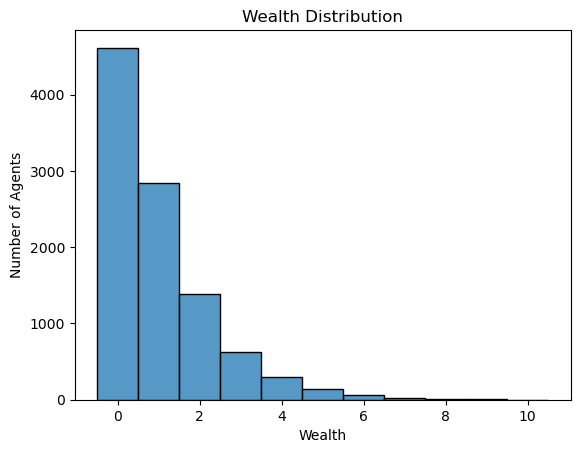

In [38]:
class MoneyAgent(mesa.Agent):
    """An agent with fixed initial wealth"""
    def __init__(self, unique_id, model):
        # To pass the parameters to the parent class
        super().__init__(unique_id, model)
        # To create the agent's variable and set the initial values
        self.wealth = 1

    def step(self):
        """The agent's step: the agent's wealth is verified, and if it has enough money, it gives money by calling the give_money function"""
        if self.wealth > 0: 
            other_agent = self.random.choice(self.model.schedule.agents)
            if other_agent is not None: 
                other_agent.wealth += 1
                self.wealth -= 1

class MoneyModel(mesa.Model):
    """A model with some number of agents"""
    def __init__(self, N):
        super().__init__()
        self.num_agents = N
        # Create scheduler and assign it to the model
        self.schedule = mesa.time.RandomActivation(self)

        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            # Add the agent to the scheduler
            self.schedule.add(a)

    def step(self):
        """Advance the model by one step"""
        self.schedule.step()

all_wealth = []
for j in range(100): 
    # Run the model
    model = MoneyModel(100)
    for i in range(100): 
        model.step()
    # Store the results 
    for agent in model.schedule.agents:
        all_wealth.append(agent.wealth)

g = sns.histplot(all_wealth, discrete=True)
g.set(title="Wealth Distribution", xlabel="Wealth", ylabel="Number of Agents");
#The semicolon is to avoid printing the object representation

Some of the code without the notes looks like this: 

In [17]:
import mesa
import seaborn as sns
import numpy as np
import pandas as pd


class MoneyAgent(mesa.Agent):
    """An agent with fixed initial wealth"""
    def __init__(self, unique_id, model):
        # To pass the parameters to the parent class
        super().__init__(unique_id, model)
        # To create the agent's variable and set the initial values
        self.wealth = 1

    def step(self):
        """The agent's step: the agent's wealth is verified, and if it has enough money, it gives money by calling the give_money function"""
        self.move()
        if self.wealth > 0: 
            self.give_money()

    def move(self):
        """To move the agent around"""
        possible_steps = self.model.grid.get_neighborhood(self.pos, moore=True, include_center=False)
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        if len(cellmates) > 1: 
            other = self.random.choice(cellmates)
            other.wealth =+ 1 
            self.wealth -= 1


class MoneyModel(mesa.Model):
    """A model with some number of agents"""
    def __init__(self, N, width, height):
        super().__init__()
        self.num_agents = N
        self.grid = mesa.space.MultiGrid(width, height, True)
        # To create a scheduler and assign it to the model
        self.schedule = mesa.time.RandomActivation(self)
        # To create agents 
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            # To add the agent to the scheduler
            self.schedule.add(a)
            # To add the agent to a random grid cell 
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))

    def step(self):
        """Advance the model by one step"""
        # The model's step goes here
        self.schedule.step()


model = MoneyModel(100, 10, 10)
for i in range(20): 
    model.step() 

agent_counts = np.zeros((model.grid.width, model.grid.height))
for cell_content, (x, y) in model.grid.coord_iter():
    agent_count = len(cell_content)
    agent_counts[x][y] = agent_count
    
g = sns.heatmap(agent_counts, cmap="viridis", annot=True, cbar=False, square=True)
g.figure.set_size_inches(4, 4)
g.set(title="Number of agents on each cell of the grid");

'\nmodel = MoneyModel(100, 10, 10)\nfor i in range(20): \n    model.step() \n\nagent_counts = np.zeros((model.grid.width, model.grid.height))\nfor cell_content, (x, y) in model.grid.coord_iter():\n    agent_count = len(cell_content)\n    agent_counts[x][y] = agent_count\n    \ng = sns.heatmap(agent_counts, cmap="viridis", annot=True, cbar=False, square=True)\ng.figure.set_size_inches(4, 4)\ng.set(title="Number of agents on each cell of the grid");\n'

# Revised Model

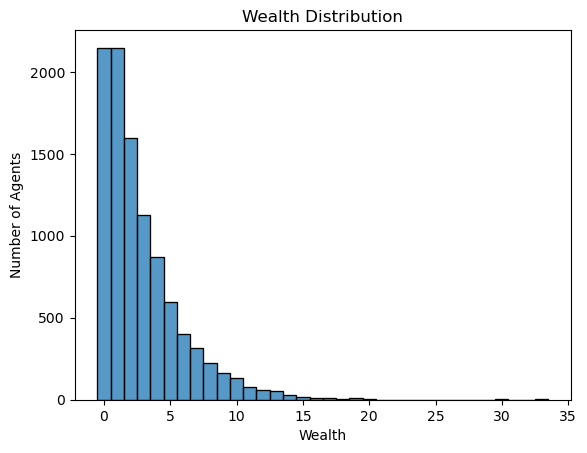

In [41]:
import random

class MoneyAgent(mesa.Agent):
    """An agent with fixed initial wealth"""
    def __init__(self, unique_id, model, wealth):
        # To pass the parameters to the parent class
        super().__init__(unique_id, model)
        # To create the agent's variable and set the initial values
        self.wealth = wealth

    def step(self):
        """The agent's step: the agent's wealth is verified, and if it has enough money, it gives money by calling the give_money function"""
        if self.wealth > 0: 
            other_agent = self.random.choice(self.model.schedule.agents)
            if other_agent is not None: 
                other_agent.wealth += 1
                self.wealth -= 1

class MoneyModel(mesa.Model):
    """A model with some number of agents"""
    def __init__(self, N):
        super().__init__()
        self.num_agents = N
        # Create scheduler and assign it to the model
        self.schedule = mesa.time.RandomActivation(self)

        # Create agents
        for i in range(self.num_agents):
            # Give the agent a 20% chance of starting with 10 units of money
            chance_of_being_wealthy = random.randint(1, 10)
            if chance_of_being_wealthy > 8: 
                wealth = 10
            else: 
                wealth = 1
            a = MoneyAgent(i, self, wealth=wealth)
            # Add the agent to the scheduler
            self.schedule.add(a)

    def step(self):
        """Advance the model by one step"""
        self.schedule.step()

all_wealth = []
for j in range(100): 
    # Run the model
    model = MoneyModel(100)
    for i in range(100): 
        model.step()
    # Store the results 
    for agent in model.schedule.agents:
        all_wealth.append(agent.wealth)

g = sns.histplot(all_wealth, discrete=True)
g.set(title="Wealth Distribution", xlabel="Wealth", ylabel="Number of Agents");
#The semicolon is to avoid printing the object representation

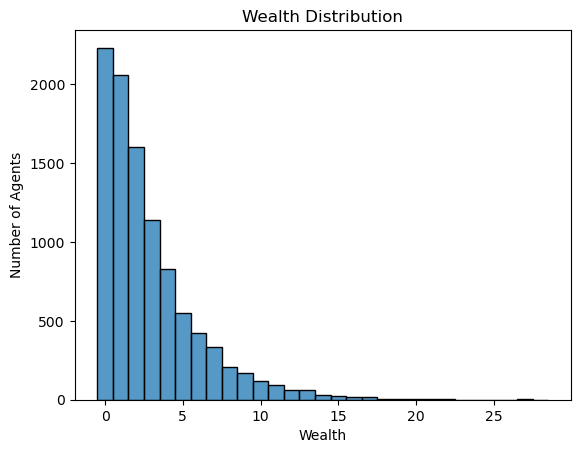

In [53]:
class MoneyAgent(mesa.Agent):
    """An agent with fixed initial wealth"""
    def __init__(self, unique_id, model, wealth):
        # To pass the parameters to the parent class
        super().__init__(unique_id, model)
        # To create the agent's variable and set the initial values
        self.wealth = wealth

    def step(self):
        """The agent's step: the agent's wealth is verified, and if it has enough money, it gives money by calling the give_money function"""
        if self.wealth > 0: 
            other_agent = self.random.choice(self.model.schedule.agents)
            if other_agent is not None: 
                other_agent.wealth += 1
                self.wealth -= 1

class MoneyModel(mesa.Model):
    """A model with some number of agents"""
    def __init__(self, N):
        super().__init__()
        self.num_agents = N
        # Create scheduler and assign it to the model
        self.schedule = mesa.time.RandomActivation(self)

        # Create agents
        for i in range(self.num_agents):
            # Give the agent a 20% chance of starting with 10 units of money
            chance_of_being_wealthy = random.randint(1, 10)
            if chance_of_being_wealthy > 8: 
                wealth = 10
            else: 
                wealth = 1
            a = MoneyAgent(i, self, wealth=wealth)
            # Add the agent to the scheduler
            self.schedule.add(a)

    def step(self):
        """Advance the model by one step"""
        self.schedule.step()

all_wealth = []
for j in range(100): 
    # Run the model
    model = MoneyModel(100)
    for i in range(100): 
        model.step()
    # Store the results 
    for agent in model.schedule.agents:
        all_wealth.append(agent.wealth)

g = sns.histplot(all_wealth, discrete=True)
g.set(title="Wealth Distribution", xlabel="Wealth", ylabel="Number of Agents");
#The semicolon is to avoid printing the object representation

  0%|          | 0/500 [00:00<?, ?it/s]

[Text(0.5, 1.0, 'Gini coefficient for different population sizes\n(mean over 100 runs)'),
 Text(0, 0.5, 'Gini Coefficient')]

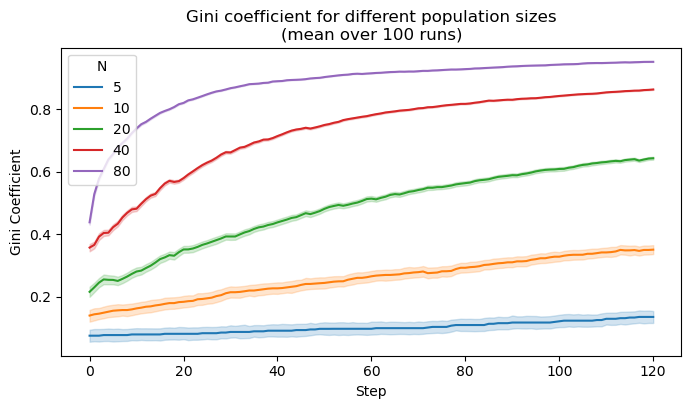

In [59]:
class MoneyAgent(mesa.Agent):
    """An agent with fixed initial wealth"""
    def __init__(self, unique_id, model, wealth):
        # To pass the parameters to the parent class
        super().__init__(unique_id, model)
        # To create the agent's variable and set the initial values
        self.wealth = wealth
        self.steps_not_given = 0 

    def step(self):
        """The agent's step: the agent's wealth is verified, and if it has enough money, it gives money by calling the give_money function"""
        self.move()
        if self.wealth > 0: 
            self.give_money()
        else: 
            self.steps_not_given += 1

    def move(self):
        """To move the agent around"""
        possible_steps = self.model.grid.get_neighborhood(self.pos, moore=True, include_center=False)
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        # To ensure that the agent is not giving money to itself
        cellmates.pop(cellmates.index(self))
        if len(cellmates) > 1: 
            other = self.random.choice(cellmates)
            other.wealth =+ 1 
            self.wealth -= 1
            self.steps_not_given = 0 
        else: 
            self.steps_not_given += 1


def compute_gini(model):
    agent_wealths = [agent.wealth for agent in model.schedule.agents]
    x = sorted(agent_wealths)
    N = model.num_agents
    B = sum(xi * (N - i) for i, xi in enumerate(x)) / (N * sum(x))
    return 1 + (1 / N) - 2 * B

class MoneyModel(mesa.Model):
    """A model with some number of agents"""
    def __init__(self, N, width, height):
        super().__init__()
        self.num_agents = N
        self.grid = mesa.space.MultiGrid(width, height, True)
        # To create a scheduler and assign it to the model
        self.schedule = mesa.time.RandomActivation(self)
        # For the batchrunner: enables conditional shut off of the model
        self.running = True 
        # To create agents 
        for i in range(self.num_agents):
            # Give the agent a very low chance of starting with 10 units of money
            chance_of_being_wealthy = random.randint(1, 100)
            if chance_of_being_wealthy > 98: 
                wealth = 100
            else: 
                wealth = 1
            a = MoneyAgent(i, self, wealth=wealth)
            # To add the agent to the scheduler
            self.schedule.add(a)
            # To add the agent to a random grid cell 
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))
        self.datacollector = mesa.DataCollector(model_reporters={"Gini": compute_gini}, agent_reporters={"Wealth": "wealth"})
        
    def step(self):
        """Advance the model by one step"""
        # The model's step goes here
        self.datacollector.collect(self)
        self.schedule.step()

params = {"width": 10, "height": 10, "N": [5, 10, 20, 40, 80]}
results_5s = mesa.batch_run(
    MoneyModel, 
    parameters=params, 
    iterations=100,
    max_steps=120,
    number_processes=1, 
    data_collection_period=1, 
    display_progress=True)

results_5s_df = pd.DataFrame(results_5s)
results_5s_df_filtered = results_5s_df[(results_5s_df.AgentID == 0)]
results_5s_df_filtered.head(3)

# Create a lineplot
g = sns.lineplot(
    data=results_5s_df, 
    x="Step",
    y="Gini",
    hue="N",
    errorbar=("ci", 95),
    palette="tab10")
g.figure.set_size_inches(8, 4)
plot_title = "Gini coefficient for different population sizes\n(mean over 100 runs)"
g.set(title=plot_title, ylabel="Gini Coefficient")

  0%|          | 0/500 [00:00<?, ?it/s]

[Text(0.5, 1.0, 'Gini coefficient for different population sizes\n(mean over 100 runs)'),
 Text(0, 0.5, 'Gini Coefficient')]

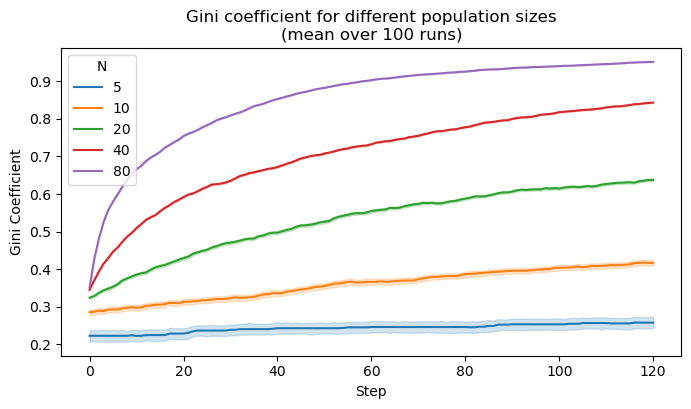

In [51]:
class MoneyAgent(mesa.Agent):
    """An agent with fixed initial wealth"""
    def __init__(self, unique_id, model, wealth):
        # To pass the parameters to the parent class
        super().__init__(unique_id, model)
        # To create the agent's variable and set the initial values
        self.wealth = wealth
        self.steps_not_given = 0 

    def step(self):
        """The agent's step: the agent's wealth is verified, and if it has enough money, it gives money by calling the give_money function"""
        self.move()
        if self.wealth > 0: 
            self.give_money()
        else: 
            self.steps_not_given += 1

    def move(self):
        """To move the agent around"""
        possible_steps = self.model.grid.get_neighborhood(self.pos, moore=True, include_center=False)
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        # To ensure that the agent is not giving money to itself
        cellmates.pop(cellmates.index(self))
        if len(cellmates) > 1: 
            other = self.random.choice(cellmates)
            other.wealth =+ 1 
            self.wealth -= 1
            self.steps_not_given = 0 
        else: 
            self.steps_not_given += 1


def compute_gini(model):
    agent_wealths = [agent.wealth for agent in model.schedule.agents]
    x = sorted(agent_wealths)
    N = model.num_agents
    B = sum(xi * (N - i) for i, xi in enumerate(x)) / (N * sum(x))
    return 1 + (1 / N) - 2 * B

class MoneyModel(mesa.Model):
    """A model with some number of agents"""
    def __init__(self, N, width, height):
        super().__init__()
        self.num_agents = N
        self.grid = mesa.space.MultiGrid(width, height, True)
        # To create a scheduler and assign it to the model
        self.schedule = mesa.time.RandomActivation(self)
        # For the batchrunner: enables conditional shut off of the model
        self.running = True 
        # To create agents 
        for i in range(self.num_agents):
            # Give the agent a 20% chance of starting with 10 units of money
            chance_of_being_wealthy = random.randint(1, 10)
            if chance_of_being_wealthy > 8: 
                wealth = 5
            else: 
                wealth = 1
            a = MoneyAgent(i, self, wealth=wealth)
            # To add the agent to the scheduler
            self.schedule.add(a)
            # To add the agent to a random grid cell 
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))
        self.datacollector = mesa.DataCollector(model_reporters={"Gini": compute_gini}, agent_reporters={"Wealth": "wealth"})
        
    def step(self):
        """Advance the model by one step"""
        # The model's step goes here
        self.datacollector.collect(self)
        self.schedule.step()

params = {"width": 10, "height": 10, "N": [5, 10, 20, 40, 80]}
results_5s = mesa.batch_run(
    MoneyModel, 
    parameters=params, 
    iterations=100,
    max_steps=120,
    number_processes=1, 
    data_collection_period=1, 
    display_progress=True)

results_5s_df = pd.DataFrame(results_5s)
results_5s_df_filtered = results_5s_df[(results_5s_df.AgentID == 0)]
results_5s_df_filtered.head(3)

# Create a lineplot
g = sns.lineplot(
    data=results_5s_df, 
    x="Step",
    y="Gini",
    hue="N",
    errorbar=("ci", 95),
    palette="tab10")
g.figure.set_size_inches(8, 4)
plot_title = "Gini coefficient for different population sizes\n(mean over 100 runs)"
g.set(title=plot_title, ylabel="Gini Coefficient")